In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import pyreadr as py
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import trange
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import random
from tg_shap import tg_shap

## DEFINICIÓN DE LAS CLASES DE LECTURA DE DATOS Y ENTRENAMIENTO DE LOS MODELOS

In [21]:
class TepDataset(Dataset):
    def __init__(self, dfX, dfAux, dfY, stride=1, window_size=10):
        self.x = np.array(dfX, dtype=np.float32)
        self.y = np.array(dfY, dtype=np.float32)
        self.simulationRun = np.array(dfAux['simulationRun'], dtype=np.int32)
        self.sample = np.array(dfAux['sample'], dtype=np.int32)
        self.window_size = window_size
        self.stride = stride
        self.valid_idxs = self._preprocess_windows(dfX, dfAux)
        
        self.n_idxs = len(self.valid_idxs)
        self.simulation_class_indices = None
        
        print(f"# of valid windows after filtering: {self.n_idxs}")

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        item = {}
        item["given"] = torch.from_numpy(self.x[i : i + self.window_size])
        
        item["answer"] = torch.from_numpy(np.array(self.y[i]))
        item["simulationRun"] = self.simulationRun[i]
        item["sample"] = self.sample[i]
        return item
    
    def _preprocess_windows(self, dfX, dfAux):
        temp_valid_idxs = []
        hash_table = {}
        for L in range(0, len(dfX) - self.window_size + 1, self.stride):
            R = L + self.window_size - 1
            if dfAux['sample'][R] - dfAux['sample'][L] == self.window_size - 1:
                temp_valid_idxs.append(L)

        return np.array(temp_valid_idxs, dtype=np.int32)

    def find_simulation_class_indices(self):
        if self.simulation_class_indices is not None:
            return self.simulation_class_indices

        diccionario_clase_simulacion = {}
        simulationRun = self[0]['simulationRun']
        clase = int(self[0]['answer'].item())

        diccionario_clase_simulacion[clase, simulationRun] = {
            'start_id': 0,
            'end_id': 0
        }

        for i in range(len(self)):
            if simulationRun != self[i]['simulationRun'] or clase != int(self[i]['answer'].item()):

                diccionario_clase_simulacion[clase, simulationRun]['end_id'] = i - 1
                
                simulationRun = self[i]['simulationRun']
                clase = int(self[i]['answer'].item())
                diccionario_clase_simulacion[clase, simulationRun] = {
                    'start_id': i,
                    'end_id': i
                }
        
        self.simulation_class_indices = diccionario_clase_simulacion


In [22]:
class StackedLSTM(torch.nn.Module):

    def __init__(self, n_tags, n_classes, hidden_size=64, num_layers=3, bidirectional=True, dropout=0):
        super().__init__()
        self.rnn = torch.nn.LSTM(
            input_size=n_tags,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
        )
        self.fc = torch.nn.Linear(2*hidden_size if bidirectional else hidden_size, n_classes)

    def forward(self, x):
        x = x.transpose(0, 1)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return out

In [23]:
def train(train_dataset, val_dataset, model, batch_size, n_epochs):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.CrossEntropyLoss() 
    epochs = trange(n_epochs, desc="training")
    
    best = {"loss": sys.float_info.max}
    best["state"] = model.state_dict()
    
    loss_history = {"train": [], "val": []}
    
    for e in epochs:        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                given = batch["given"].to(device)
                guess = model(given)  
                answer = batch["answer"].long().to(device)  
                loss = loss_fn(guess, answer)
                val_loss += loss.item()
        
        val_loss /= len(val_dataloader)
        loss_history["val"].append(val_loss)
        
        model.train()
        epoch_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()
            given = batch["given"].to(device)
            guess = model(given)  
            answer = batch["answer"].long().to(device)  
            loss = loss_fn(guess, answer)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        
        epoch_loss /= len(train_dataloader)
        loss_history["train"].append(epoch_loss)        
        
        # Update progress bar
        epochs.set_postfix_str(f"loss: {epoch_loss:.3f}, val_loss: {val_loss:.3f}")
        
        # Save best model
        if val_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = val_loss
            best["epoch"] = e + 1
    
    return best, loss_history

In [24]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    simulationRun, samples, preds, labels, prob = [], [], [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].to(device)
            true_labels = batch.get("answer").to(device) if "answer" in batch else None
            outputs = model(given).to(device)
            #probabilities = outputs
            probabilities = torch.softmax(outputs, dim=1)  # Aplica softmax para obtener probabilidades
            predicted_classes = torch.argmax(probabilities, dim=1)  # Encuentra la clase con la probabilidad más alta
            prob.append(probabilities.cpu().numpy())
            preds.append(predicted_classes.cpu().numpy())
            if true_labels is not None:
                labels.append(true_labels.cpu().numpy())  # Guarda las etiquetas reales para comparar
                
            simulationRun.append(batch["simulationRun"].numpy())
            samples.append(batch["sample"].numpy())
    return (
        np.concatenate(preds),
        np.concatenate(labels) if len(labels) > 0 else np.array([]),
        np.concatenate(simulationRun),
        np.concatenate(samples),
        np.concatenate(prob, axis=0)
    )

## LECTURA DEL CONUJUNTO DE DATOS

Los datos están disponibles [aquí](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1)

In [25]:
#reading train data in .R format
a1 = py.read_r("TEP_FaultFree_Training.RData")
a2 = py.read_r("TEP_Faulty_Training.RData")

#reading test data in .R format
a3 = py.read_r("TEP_FaultFree_Testing.RData")
a4 = py.read_r("TEP_Faulty_Testing.RData")


#reading train data
b1 = a1['fault_free_training']
b2 = a2['faulty_training']
#reading test data
b3 = a3['fault_free_testing']
b4 = a4['faulty_testing']

In [26]:
b1 = b1[b1['simulationRun'] <= 100]   
b1 = b1[b1['sample'] > 100]
b2 = b2[b2['simulationRun'] <= 100]
b2 = b2[b2['sample'] > 100]

b2 = b2[b2['faultNumber'] != 3]
b2 = b2[b2['faultNumber'] != 9]
b2 = b2[b2['faultNumber'] != 15]

b3 = b3[b3['simulationRun'] <= 100]
b3 = b3[b3['sample'] > 250]
b4 = b4[b4['simulationRun'] <= 100]
b4 = b4[b4['sample'] > 250]

b4 = b4[b4['faultNumber'] != 3]
b4 = b4[b4['faultNumber'] != 9]
b4 = b4[b4['faultNumber'] != 15]

In [27]:
random.seed(42)
random_list = random.sample(range(1, 101), 20)

b1_tr = b1[~b1['simulationRun'].isin(random_list)]
b1_val = b1[b1['simulationRun'].isin(random_list)]


b2_tr = b2[~b2['simulationRun'].isin(random_list)]
b2_val = b2[b2['simulationRun'].isin(random_list)]

In [28]:
training = pd.concat([b1_tr,b2_tr], axis=0, ignore_index=True)
validation = pd.concat([b1_val,b2_val], axis=0, ignore_index=True)
test = pd.concat([b3,b4], axis=0, ignore_index=True)

training['faultNumber'] = training['faultNumber'].astype('category')
validation['faultNumber'] = validation['faultNumber'].astype('category')
test['faultNumber'] = test['faultNumber'].astype('category')

x_tr = training.drop(['faultNumber','simulationRun','sample'], axis=1)
y_tr = training['faultNumber']
media = x_tr.mean()
std = x_tr.std()
x_tr = (x_tr - media) / std

x_val = validation.drop(['faultNumber','simulationRun','sample'], axis=1)
y_val = validation['faultNumber']
x_val = (x_val - media) / std

x_te = test.drop(['faultNumber','simulationRun','sample'], axis=1)
y_te = test['faultNumber']
x_te = (x_te - media) / std

In [29]:
TepDatasetTrain = TepDataset(x_tr, training[['faultNumber','simulationRun','sample']], y_tr, stride=5, window_size=10)
TepDatasetVal = TepDataset(x_val, validation[['faultNumber','simulationRun','sample']], y_val, stride=5, window_size=10)
TepDatasetTest = TepDataset(x_te, test[['faultNumber','simulationRun','sample']], y_te, stride=5, window_size=10)

# of valid windows after filtering: 113760
# of valid windows after filtering: 28440
# of valid windows after filtering: 253800


## ENTRENAMIENTO DEL MODELO

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL = StackedLSTM(n_tags=52, n_classes=21, hidden_size=64, num_layers=3, bidirectional=True, dropout=0).to(device)

In [31]:
trainBinary = False

if trainBinary:
    MODEL.train()
    best, loss_history = train(TepDatasetTrain, TepDatasetVal, MODEL, batch_size=1024, n_epochs=32)
    #torch.save(best["state"], "model_shap.pth")
else:
    MODEL.load_state_dict(torch.load("model_shap.pth"))
    

Accuracy: 0.977002


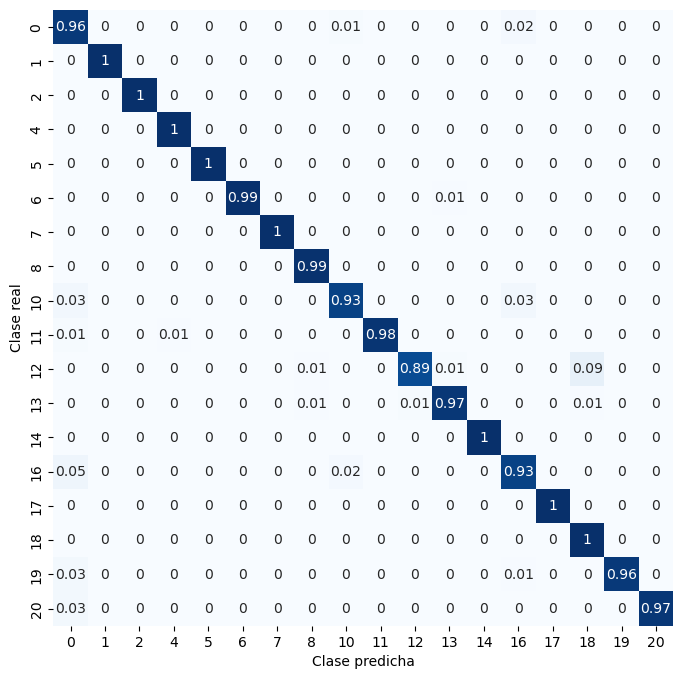

In [32]:
def format_cm_values(cm):
    formatted_cm = np.char.mod('%.2f', cm)
    formatted_cm[formatted_cm == '0.00'] = '0'
    formatted_cm[formatted_cm == '1.00'] = '1'
    return formatted_cm
    

MODEL.eval()

with torch.no_grad():
    preds, labels, simulationRuns, samples, probs = inference(TepDatasetTest, MODEL, batch_size=512)

    print(f"Accuracy: {accuracy_score(labels, preds):.6f}")

    cm = confusion_matrix(labels, preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    formatted_cm = format_cm_values(cm_percent)

    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm_percent, annot=formatted_cm, fmt="", cmap="Blues", cbar=False, ax=ax, 
                xticklabels=[0,1,2,4,5,6,7,8,10,11,12,13,14,16,17,18,19,20], 
                yticklabels=[0,1,2,4,5,6,7,8,10,11,12,13,14,16,17,18,19,20])
    ax.set_xlabel("Clase predicha")
    ax.set_ylabel("Clase real")
    
    plt.show()

## APLICACIÓN DE TG_SHAP AL MODELO ENTRENADO

In [33]:
random_list = random.sample(range(0, len(TepDatasetTrain)), 100)

Support = [TepDatasetTrain[i] for i in random_list]

Test = [TepDatasetTest[i] for i in range(0, 50)]

In [34]:
sumas, todas_prob, diccionario_shap_aciertos, df = tg_shap(MODEL, Support, Test, 10)

0
Suma de importancias: tensor(1.0456, device='cuda:0')
Probabilidad original: 0.9525123834609985
1
Suma de importancias: tensor(1.0991, device='cuda:0')
Probabilidad original: 0.9757768511772156
2
Suma de importancias: tensor(1.0759, device='cuda:0')
Probabilidad original: 0.9636731147766113
3
Suma de importancias: tensor(1.0486, device='cuda:0')
Probabilidad original: 0.9582410454750061
4
Suma de importancias: tensor(0.9969, device='cuda:0')
Probabilidad original: 0.9172705411911011
5
Suma de importancias: tensor(0.5470, device='cuda:0')
Probabilidad original: 0.5208953022956848
6
Suma de importancias: tensor(0.9330, device='cuda:0')
Probabilidad original: 0.8856151700019836
7
Suma de importancias: tensor(1.0440, device='cuda:0')
Probabilidad original: 0.9552255272865295
8
Suma de importancias: tensor(1.0467, device='cuda:0')
Probabilidad original: 0.9485407471656799
9
Suma de importancias: tensor(0.9568, device='cuda:0')
Probabilidad original: 0.9037039279937744
10
Suma de importanc

In [35]:
df

,idx,k,simulationRun,sample,clase_predicha,clase_real,shap1,shap2,shap3,shap4,shap5,shap6,shap7,shap8,shap9,shap10,prob_predicha,suma_shap,aciertos
0,0,100,1,251,0,0.0,0.092561,0.109713,0.097425,0.119614,0.101872,0.110595,0.111045,0.100094,0.105355,0.097347,0.952512,1.045622,1
1,1,100,1,256,0,0.0,0.104117,0.109521,0.117235,0.109908,0.105793,0.113622,0.125761,0.106273,0.101596,0.105283,0.975777,1.099108,1
2,2,100,1,261,0,0.0,0.099268,0.115407,0.109325,0.109909,0.106417,0.094179,0.108587,0.113605,0.114109,0.105132,0.963673,1.075938,1
3,3,100,1,266,0,0.0,0.096141,0.108179,0.109228,0.108903,0.108261,0.105760,0.096253,0.100752,0.112287,0.102816,0.958241,1.048579,1
4,4,100,1,271,0,0.0,0.085576,0.091230,0.112489,0.109988,0.106308,0.111577,0.117807,0.105336,0.078802,0.077833,0.917271,0.996946,1
5,5,100,1,276,10,0.0,0.032624,0.048028,0.038218,0.066677,0.059337,0.062681,0.068145,0.072203,0.054897,0.044202,0.520895,0.547012,0
6,6,100,1,281,0,0.0,0.080139,0.093093,0.086483,0.087622,0.107055,0.094577,0.113569,0.093637,0.083477,0.093373,0.885615,0.933025,1
7,7,100,1,286,0,0.0,0.093435,0.106084,0.095500,0.111648,0.098699,0.108135,0.121882,0.107965,0.099653,0.101004,0.955226,1.044004,1
8,8,100,1,291,0,0.0,0.094966,0.103977,0.099362,0.100208,0.106343,0.086454,0.103863,0.092509,0.133258,0.125765,0.948541,1.046706,1
9,9,100,1,296,0,0.0,0.083741,0.083295,0.063541,0.097613,0.109838,0.113988,0.109042,0.105164,0.100099,0.090454,0.903704,0.956775,1
